In [119]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Create Franke Function and plot

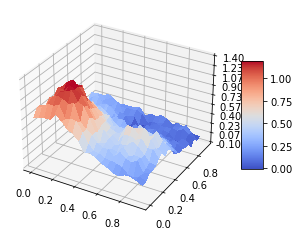

In [120]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    noise = np.random.normal(0, 0.05, len(x)*len(x))
    noise = noise.reshape(len(x),len(x))
    return term1 + term2 + term3 + term4 + noise


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Make design matrix with polynomial degree n

In [121]:
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of columns in beta
	X = np.ones((N,l)) # matrix with N rows, l columns

	for i in range(1,n+1): # 1-6
		q = int((i)*(i+1)/2) # 1 3 6 10 15 21
		for k in range(i+1): # 0-1, 0-2, 0-3,...
			X[:,q+k] = (x**(i-k))*(y**k)

	return X


# Making meshgrid of datapoints and compute Franke's function
n = 5
N = 1000
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
z = FrankeFunction(x, y)
X = create_X(x, y, n=n)

## Split train/test

In [ ]:
X_train, X_test, z_train, z_test = train_test_split(X,z, test_size=0.2)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # to not scale, just put = X_train instead of changing everywhere
X_test_scaled = scaler.transform(X_test)

## Error functions

In [129]:
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

## OLS regression linalg

In [130]:
beta_ols = np.linalg.pinv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ z_train

ztilde_ols_train = X_train_scaled @ beta_ols
ztilde_ols_test = X_test_scaled @ beta_ols

print('R2 OLS train: %.10f' %(R2(z_train,ztilde_ols_train)))
print('R2 OLS test: %.10f' %(R2(z_test,ztilde_ols_test)))
print('mse OLS train: %.10f' %(MSE(z_train,ztilde_ols_train)))
print('mse OLS test: %.10f' %(MSE(z_test,ztilde_ols_test)))

R2 OLS train: -1.4674861780
R2 OLS test: -1.4685089975
mse OLS train: 0.4415227835
mse OLS test: 0.4415785972


## OLS regression scikit

In [131]:
linreg = LinearRegression()
linreg.fit(X_train_scaled,z_train)
ztilde_ols_train_scikit = linreg.predict(X_train_scaled)
ztilde_ols_test_scikit = linreg.predict(X_test_scaled)

# Error functions manually implemented
print('R2 OLS train: %.10f' %(R2(z_train,ztilde_ols_train_scikit)))
print('R2 OLS test: %.10f' %(R2(z_test,ztilde_ols_test_scikit)))
print('mse OLS train: %.10f' %(MSE(z_train,ztilde_ols_train_scikit)))
print('mse OLS test: %.10f' %(MSE(z_test,ztilde_ols_test_scikit)))

# Error functions in scikit library
print('R2 OLS train scikit: %.10f' %(r2_score(z_train,ztilde_ols_train_scikit)))
print('R2 OLS test scikit: %.10f' %(r2_score(z_test,ztilde_ols_test_scikit)))
print('mse OLS train scikit: %.10f' %(mean_squared_error(z_train,ztilde_ols_train_scikit)))
print('mse OLS test scikit: %.10f' %(mean_squared_error(z_test,ztilde_ols_test_scikit)))

R2 OLS train: 0.9864104852
R2 OLS test: 0.9856609930
mse OLS train: 0.0024316571
mse OLS test: 0.0025650296
R2 OLS train scikit: 0.0247901917
R2 OLS test scikit: -0.0315529586
mse OLS train scikit: 0.0024316571
mse OLS test scikit: 0.0025650296


## Ridge regression

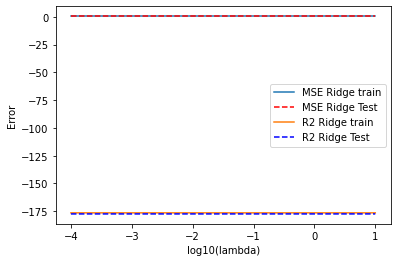

In [136]:
nlambdas = 20
MSE_train = np.zeros(nlambdas)
MSE_test = np.zeros(nlambdas)
R2_train = np.zeros(nlambdas)
R2_test = np.zeros(nlambdas)
lambdas = np.logspace(-4, 1, nlambdas)

for i in range(nlambdas):
    lmd = lambdas[i]
    beta_ridge = np.linalg.pinv(X_train_scaled.T @ X_train_scaled + lmd*np.eye(X_train_scaled.shape[1], X_train_scaled.shape[1])) @ X_train_scaled.T @ z_train
    ztilde_train_ridge = X_train_scaled @ beta_ridge
    ztilde_test_ridge = X_test_scaled @ beta_ridge
    
    MSE_train[i] = mean_squared_error(z_train, ztilde_train_ridge)
    MSE_test[i] = mean_squared_error(z_test, ztilde_test_ridge)
    R2_train[i] = r2_score(z_train, ztilde_train_ridge)
    R2_test[i] = r2_score(z_test, ztilde_test_ridge)

plt.plot(np.log10(lambdas), MSE_train, label = 'MSE Ridge train')
plt.plot(np.log10(lambdas), MSE_test, 'r--', label = 'MSE Ridge Test')
plt.plot(np.log10(lambdas), R2_train, label = 'R2 Ridge train')
plt.plot(np.log10(lambdas), R2_test, 'b--', label = 'R2 Ridge Test')
plt.xlabel('log10(lambda)')
plt.ylabel('Error')
plt.legend()
plt.show()